I will apply Google Brand Lift to estimating lift from TrueView advertising campaigns, with surveys on YouTube. In this case we use a randomized experiment. Users are assigned to experiment (i.e. treatment) or control using random number generation based on a
hashed version of their cookies.

Below I have addressed different stages of the advertising funnel: ad recall, brand awareness, consideration, etc.

For example, for ad recall a typical multiple choice question is: “Which of the following online ads have you seen recently?”, where one of the choices
is the target brand. Similarly, a brand awareness question is “Which of the following brands have you heard of?”

The dataset I used includes data from one campaign and a single question about recall.  More details on the data are given below.

Data comes from three different sources: Exposures, survey solicitations, and survey responses. Each file is a CSV file and will contain a header with column names.  The timestamp in all files is "Unix Time" - which is the number of seconds since Jan 1st, 1970. More information is available [here](https://en.wikipedia.org/wiki/Unix_time). For exposure data, the columns are:
* timestamp: time of the exposure
* user_id: a unique identifier for the user
* group: whether the user was assigned to the control group, or the experiment group.
* gender: Female (F), Male (M), or Other/Uknown (O)
* age: five different age buckets <p>

For survey solicitations, the columns are:

* user_id: a unique identifier for the user.
* timestamp: time of the survey solicitation <p>

For responses, the columns are:

* user_id: a unique identifier for the user.
* timestamp: the timestamp of the response
* positive response: 0 or 1, where 1 indicates the user responded positively (i.e. the "correct answer" to the question.)

Warning -> We can simply join the data sources as they are. If you attempt this, you will get results that do not make sense.  Specifically, the exposure data contains multiple exposures per user, and you should carefully consider how you will handle this.


In [1]:
# Importing Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
exposures_url = 'https://github.com/hangingbelay/spring2024/raw/main/homework_2_exposures.csv.gz'
exposure_data = pd.read_csv(exposures_url)

solicitations_url = 'https://github.com/hangingbelay/spring2024/raw/main/homework_2_solicitations.csv.gz'
solicitation_data = pd.read_csv(solicitations_url)

responses_url = 'https://github.com/hangingbelay/spring2024/raw/main/homework_2_responses.csv.gz'
response_data = pd.read_csv(responses_url)

In [3]:
# Dataset Summary

# Exposure Data
print(exposure_data.info())
print('\n')

# Solicitation Data
print(solicitation_data.info())
print('\n')

# Response Data
print(response_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2169810 entries, 0 to 2169809
Data columns (total 5 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   user_id    int64 
 2   group      object
 3   gender     object
 4   age        object
dtypes: int64(2), object(3)
memory usage: 82.8+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104619 entries, 0 to 104618
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    104619 non-null  int64
 1   timestamp  104619 non-null  int64
dtypes: int64(2)
memory usage: 1.6 MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73149 entries, 0 to 73148
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   user_id            73149 non-null  int64
 1   timestamp          73149 non-null  int64
 2   positive_response  73149 non-null  int64
dtypes: int64(3)
mem

In [4]:
# Datasets First 6 Rows

# Exposure Data
print(exposure_data.head())
print('\n')

# Solicitation Data
print(solicitation_data.head())
print('\n')

# Response Data
print(response_data.head())


    timestamp   user_id       group gender    age
0  1706770800  80936544     CONTROL      M  18-29
1  1706770800  87175094     CONTROL      F  40-49
2  1706770803  49589178  EXPERIMENT      M    65+
3  1706770805   3867881  EXPERIMENT      F  30-39
4  1706770807  35409191  EXPERIMENT      F  18-29


   user_id   timestamp
0  1000602  1707900206
1  1001043  1707366013
2  1001466  1707475365
3  1002204  1707338185
4  1002206  1708109310


   user_id   timestamp  positive_response
0  1001466  1707475374                  0
1  1002204  1707338195                  0
2  1002206  1708109315                  0
3  1004063  1707105330                  0
4  1005165  1708058353                  0


### Comparing Proportions from two different groups

One of the key metrics we are interested in analyzing is the difference in the proportion of positive responses between the experiment group and the control group.  

It is important to not only look at the point estimates, but also the uncertainty of those estimates.  This helps understand if observed differences are due to chance or due to a real underlying effect.

Here I am using the point estimates for the **difference** in response rate between the experiment group and control group, and a confidence interval on this difference.  This is a more direct and natural way to compare the differences between two groups.

For example, suppose that the response rate in the experiment group is 50%, and the response rate in the control group is 42%.  The difference is 50% - 42% = 8%.  If we know the sample sizes from each group, we can also compute a confidence interval (code is given below).  Suppose the confidence interval is from 2% - 14%.  In this case, we would say that the difference between the experiment group and control group is statistically different from zero since the lower bound of the confidence interval is greater than 0.  This indicates there is only a small chance that these results are due to randomness, and the difference is due to a real effect.

If the confidence interval did include 0 (i.e. the lower bound is negative and the upper bound is positive) then the difference could be due to random chance.

Here is a function you can use with a groupby statement to output both a point estimate of the difference and the confidence interval for the difference.  Please copy this code directly and use it.

In [5]:
def two_sample_conf_interval(df):
  critical_value = 1.96
  exp_data = df[df['group'] == "EXPERIMENT"]
  p1 = exp_data['positive_response'].mean()
  se_1 = 0
  if exp_data.shape[0] > 0:
    se_1 = np.sqrt(p1 * (1 - p1) / exp_data.shape[0])

  control_data = df[df['group'] == "CONTROL"]
  p2 = control_data['positive_response'].mean()
  se_2 = 0
  if control_data.shape[0] > 0:
    se_2 = np.sqrt(p2 * (1 - p2) / control_data.shape[0])

  se = np.sqrt(se_1*se_1 + se_2*se_2)

  p_diff = p1 - p2
  return pd.Series([p_diff.round(4), "(%.4f - %.4f)" % (p_diff - critical_value * se, p_diff + critical_value * se)],
                   index=['diff', 'conf interval'])

You can use this function with a groupby statement, assuming your dataframe has columns named "group" and "positive_response" (which are the column names in the data you are given).  

To do so, we use the 'apply()' method for groupby.  

**Note:** that we **DO NOT** use 'group' as one of the groupby variables.  If you do this, you will get a result with all NaNs.  

Here is an example of how to correctly use this:

```
# assume df has column names gender, group, positive_response
df.groupby(['gender']).apply(two_sample_conf_interval)
```

Here I will compute the key results of the overall experiment

In [6]:
# Convert timestamp to datetime

exposure_data['timestamp'] = pd.to_datetime(exposure_data['timestamp'], unit='s')

solicitation_data['timestamp'] = pd.to_datetime(solicitation_data['timestamp'], unit='s')

response_data['timestamp'] = pd.to_datetime(response_data['timestamp'], unit='s')

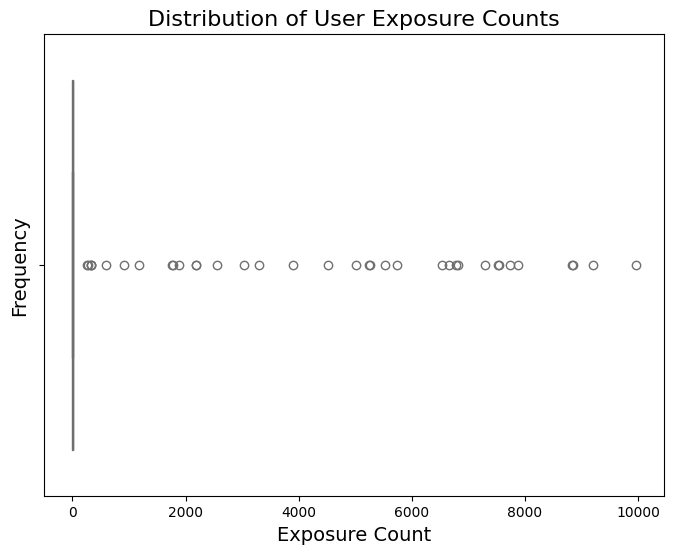


Number of outliers: 36

Outliers:
user_id
34182077    9967
79669730    9197
63556434    8856
66926743    8831
99299209    7877
31651821    7736
47233356    7546
22602415    7527
33079874    7295
81305319    6823
23015855    6774
23800997    6652
85481707    6541
12855128    5746
31000189    5527
28479729    5261
67722790    5244
45227429    5014
30044379    4525
96606418    3904
63492801    3298
73724469    3027
32197113    2558
33661379    2186
18312665    2186
82269980    1881
43154350    1784
2848378     1762
24220692    1185
15637817     915
29116819     586
2077598      336
37797678     333
83416469     333
40796383     274
89745429     258
Name: count, dtype: int64


In [7]:
# Checking for outliers in data

exposure_counts = exposure_data['user_id'].value_counts()

# Set the size of the plot
plt.figure(figsize=(8, 6))

# Create the box plot using Seaborn
sns.boxplot(x=exposure_counts, color='skyblue')

# Set plot title and labels
plt.title('Distribution of User Exposure Counts', fontsize=16)
plt.xlabel('Exposure Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

# Calculating the quartiles and IQR
Q1 = exposure_counts.quantile(0.25)
Q3 = exposure_counts.quantile(0.75)
IQR = Q3 - Q1

# Calculate upper and lower bounds
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Detect the Outliers
outlier_list = exposure_counts[(exposure_counts > upper_bound) | (exposure_counts < lower_bound)]

print(f"\nNumber of outliers: {len(outlier_list)}")

print("\nOutliers:")
print(outlier_list)

In [8]:
# Filtering out the dataframes to remove duplicates and get unique users with the last timestamp

# Filter exposure_data for unique users with the last timestamp
filtered_exposure_data = exposure_data.loc[exposure_data.groupby('user_id')['timestamp'].idxmax()]

# Filter solicitation_data for unique users with the last timestamp
filtered_solicitation_data = solicitation_data.loc[solicitation_data.groupby('user_id')['timestamp'].idxmax()]

# Filter response_data for unique users with the last timestamp
filtered_response_data = response_data.loc[response_data.groupby('user_id')['timestamp'].idxmax()]

In [9]:
# Exposure Data
print(filtered_exposure_data.info())
print('\n')

# Solicitation Data
print(filtered_solicitation_data.info())
print('\n')

# Response Data
print(filtered_response_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 1275682 to 1727300
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1000000 non-null  datetime64[ns]
 1   user_id    1000000 non-null  int64         
 2   group      1000000 non-null  object        
 3   gender     1000000 non-null  object        
 4   age        1000000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 45.8+ MB
None


<class 'pandas.core.frame.DataFrame'>
Index: 104619 entries, 0 to 104618
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    104619 non-null  int64         
 1   timestamp  104619 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 MB
None


<class 'pandas.core.frame.DataFrame'>
Index: 73149 entries, 0 to 73148
Data columns (total 3 columns):
 # 

In [10]:
# Checking for null values

print(filtered_exposure_data.isnull().sum())
print('\n')
print(filtered_solicitation_data.isnull().sum())
print('\n')
print(filtered_response_data.isnull().sum())

timestamp    0
user_id      0
group        0
gender       0
age          0
dtype: int64


user_id      0
timestamp    0
dtype: int64


user_id              0
timestamp            0
positive_response    0
dtype: int64


Grouped Data based on Solicitation Gap:
       solicitation_gap  count
0              1.038171      1
1              1.048692      1
2              1.054271      1
3              1.058426      1
4              1.062326      1
...                 ...    ...
45820          6.995012      1
45821          6.995637      1
45822          6.995660      1
45823          6.998530      1
45824          6.999363      1

[45825 rows x 2 columns]


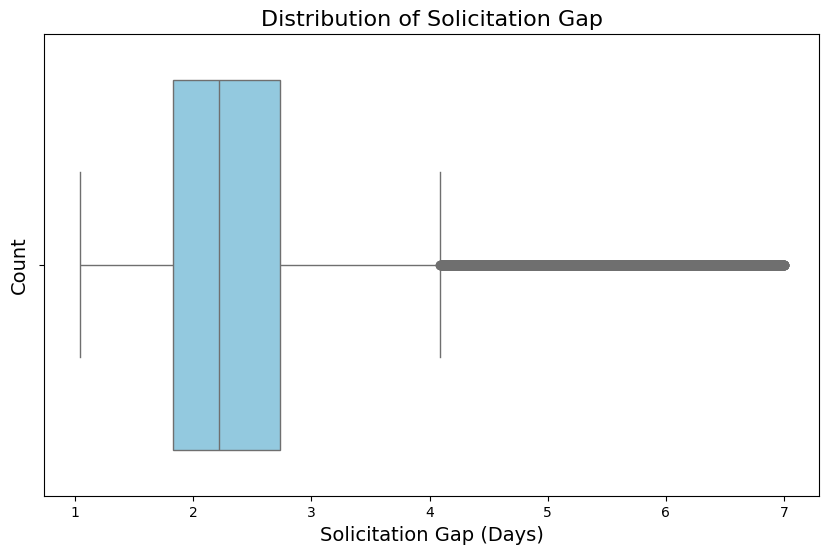

In [11]:
# Computing Solicitation Gap

# Merge exposure_data and solicitation_data
merged_data_soliGap = pd.merge(filtered_exposure_data, filtered_solicitation_data, on='user_id', suffixes=('_exposure', '_solicitation'), how = 'right')

# Checking for only Experiment Group
merged_data_soliGap = merged_data_soliGap[merged_data_soliGap['group'] == 'EXPERIMENT']

# Compute solicitation gap in days
merged_data_soliGap['solicitation_gap'] = (merged_data_soliGap['timestamp_solicitation'] - merged_data_soliGap['timestamp_exposure']).dt.total_seconds()
merged_data_soliGap['solicitation_gap'] = merged_data_soliGap['solicitation_gap'] / (60 * 60 * 24)

# Group the data based on solicitation gap and count the occurrences
grouped_data_soliGap = merged_data_soliGap.groupby('solicitation_gap').size().reset_index(name='count')

print("Grouped Data based on Solicitation Gap:")
print(grouped_data_soliGap)

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Plot the boxplot using Seaborn
sns.boxplot(x='solicitation_gap', data=grouped_data_soliGap, color='skyblue')

# Set plot title and labels
plt.title('Distribution of Solicitation Gap', fontsize=16)
plt.xlabel('Solicitation Gap (Days)', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show the plot
plt.show()

In [12]:
# Merge with filtered_response_data for solicitation gaps less than 4 days
response_data_less_than_4 = pd.merge(merged_data_soliGap[merged_data_soliGap['solicitation_gap'] < 4],
                                      filtered_response_data,
                                      on='user_id',
                                      how='inner')

# Merge with filtered_response_data for solicitation gaps greater than 4 days
response_data_greater_than_4 = pd.merge(merged_data_soliGap[merged_data_soliGap['solicitation_gap'] >= 4],
                                         filtered_response_data,
                                         on='user_id',
                                         how='inner')

# Calculate total positive responses for each group
total_positive_responses_less_than_4 = response_data_less_than_4['positive_response'].sum()
total_positive_responses_greater_than_4 = response_data_greater_than_4['positive_response'].sum()

# Calculate total responses for each group
total_responses_less_than_4 = response_data_less_than_4.shape[0]
total_responses_greater_than_4 = response_data_greater_than_4.shape[0]

# Calculate response rate for solicitation gaps less than 4 days
response_rate_less_than_4 = (total_positive_responses_less_than_4 / total_responses_less_than_4) * 100

# Calculate response rate for solicitation gaps greater than 4 days
response_rate_greater_than_4 = (total_positive_responses_greater_than_4 / total_responses_greater_than_4) * 100

print("Response Rate for Solicitation Gaps Less Than 4 Days:", response_rate_less_than_4.round(2))
print("Response Rate for Solicitation Gaps Greater Than 4 Days:", response_rate_greater_than_4.round(2))

Response Rate for Solicitation Gaps Less Than 4 Days: 12.89
Response Rate for Solicitation Gaps Greater Than 4 Days: 25.73


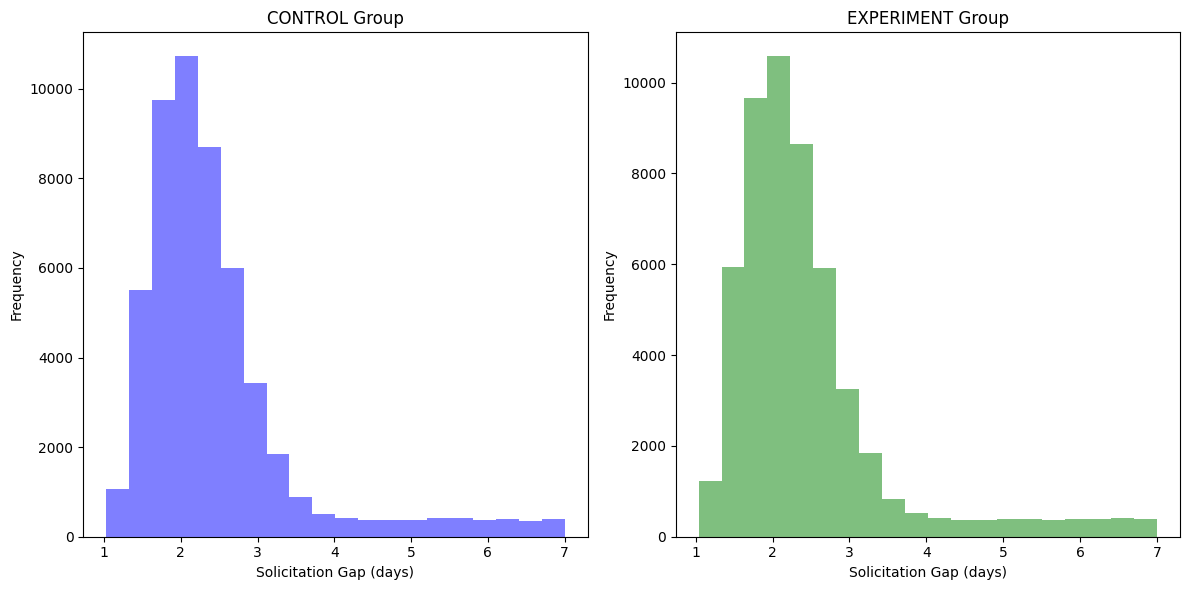

In [13]:
# Merge exposure_data and solicitation_data for both CONTROL and EXPERIMENT groups
merged_data_control = pd.merge(filtered_exposure_data[filtered_exposure_data['group'] == 'CONTROL'], filtered_solicitation_data, on='user_id', suffixes=('_exposure', '_solicitation'), how='right')
merged_data_experiment = pd.merge(filtered_exposure_data[filtered_exposure_data['group'] == 'EXPERIMENT'], filtered_solicitation_data, on='user_id', suffixes=('_exposure', '_solicitation'), how='right')

# Compute solicitation gap in days for CONTROL group
merged_data_control['solicitation_gap'] = (merged_data_control['timestamp_solicitation'] - merged_data_control['timestamp_exposure']).dt.total_seconds() / (60 * 60 * 24)

# Compute solicitation gap in days for EXPERIMENT group
merged_data_experiment['solicitation_gap'] = (merged_data_experiment['timestamp_solicitation'] - merged_data_experiment['timestamp_exposure']).dt.total_seconds() / (60 * 60 * 24)

# Plot histograms for solicitation gap for both groups
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for CONTROL group
axes[0].hist(merged_data_control['solicitation_gap'], bins=20, alpha=0.5, color='blue')
axes[0].set_title('CONTROL Group')
axes[0].set_xlabel('Solicitation Gap (days)')
axes[0].set_ylabel('Frequency')

# Plot histogram for EXPERIMENT group
axes[1].hist(merged_data_experiment['solicitation_gap'], bins=20, alpha=0.5, color='green')
axes[1].set_title('EXPERIMENT Group')
axes[1].set_xlabel('Solicitation Gap (days)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

In [14]:
# Computing the solicitation rate

# Merge filtered exposure_data with response_data to get exposed users who were solicited
exposed_and_solicited = pd.merge(filtered_exposure_data, filtered_solicitation_data, on='user_id', how='inner')

# Calculate overall solicitation rate
overall_solicitation_rate = (len(exposed_and_solicited) / len(filtered_exposure_data)) * 100

# Calculate the number of exposed users in each group
exposed_users_grouped = filtered_exposure_data.groupby('group').size().reset_index(name='exposed_count')

# Calculate the number of exposed users who were solicited in each group
solicited_users_grouped = exposed_and_solicited.groupby('group').size().reset_index(name='solicited_count')

# Merge exposed and solicited counts by group
grouped_data = pd.merge(exposed_users_grouped, solicited_users_grouped, on='group', how='left')

# Calculate solicitation rate for each group
grouped_data['solicitation_rate'] = (grouped_data['solicited_count'] / grouped_data['exposed_count']) * 100

print("Overall Solicitation Rate:",round(overall_solicitation_rate, 3))
print("\nSolicitation Rate by Group:")
print(grouped_data[['group', 'solicitation_rate']])

Overall Solicitation Rate: 10.462

Solicitation Rate by Group:
        group  solicitation_rate
0     CONTROL          17.438067
1  EXPERIMENT           7.470334


In [15]:
# Computing the response rate (positive response rate)

# Merge filtered exposure_data with response_data to get exposed users who responded
exposed_and_responded = pd.merge(filtered_exposure_data, filtered_response_data, on='user_id', how='inner')

# Calculate overall response rate
overall_response_rate = (exposed_and_responded['positive_response'].sum() / len(exposed_and_responded)) * 100

# Calculate the number of positive responses and total number of responses for each group
responses_grouped = exposed_and_responded.groupby('group')['positive_response'].agg(['sum', 'count']).reset_index()

# Calculate response rate for each group
responses_grouped['response_rate'] = (responses_grouped['sum'] / responses_grouped['count']) * 100


print("Overall Response Rate:",round(overall_response_rate, 3))
print("\nResponse Rate by Group:")
print(responses_grouped[['group', 'response_rate']])

Overall Response Rate: 12.831

Response Rate by Group:
        group  response_rate
0     CONTROL      11.796599
1  EXPERIMENT      13.862954


In [16]:
# Confidence Intervals

merged_data = pd.merge(filtered_exposure_data, filtered_response_data, on = 'user_id', how = 'left')

# Age
print('Age:')
print(merged_data.groupby(['gender']).apply(two_sample_conf_interval))

# Gender
print('\nGender:')
print(merged_data.groupby(['age']).apply(two_sample_conf_interval))

# Gender & Age
print('\nGender & Age:')
print(merged_data.groupby(['gender', 'age']).apply(two_sample_conf_interval))

Age:


<ipython-input-16-e108303fd18c>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(merged_data.groupby(['gender']).apply(two_sample_conf_interval))


          diff      conf interval
gender                           
F       0.0342  (0.0322 - 0.0362)
M       0.0073  (0.0053 - 0.0093)
O       0.0181  (0.0080 - 0.0282)

Gender:


<ipython-input-16-e108303fd18c>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(merged_data.groupby(['age']).apply(two_sample_conf_interval))


         diff      conf interval
age                             
18-29  0.0185  (0.0152 - 0.0219)
30-39  0.0256  (0.0224 - 0.0288)
40-49  0.0363  (0.0336 - 0.0390)
50-64  0.0041  (0.0009 - 0.0072)
65+    0.0105  (0.0070 - 0.0141)

Gender & Age:
                diff        conf interval
gender age                               
F      18-29  0.0242    (0.0194 - 0.0290)
       30-39  0.0522    (0.0475 - 0.0569)
       40-49  0.0671    (0.0632 - 0.0710)
       50-64  0.0020   (-0.0024 - 0.0065)
       65+    0.0065    (0.0014 - 0.0115)
M      18-29  0.0160    (0.0112 - 0.0207)
       30-39  0.0022   (-0.0023 - 0.0066)
       40-49  0.0030   (-0.0009 - 0.0068)
       50-64  0.0070    (0.0026 - 0.0115)
       65+    0.0125    (0.0074 - 0.0176)
O      18-29 -0.0520  (-0.0795 - -0.0246)
       30-39 -0.0397  (-0.0603 - -0.0191)
       40-49  0.1055    (0.0878 - 0.1233)
       50-64 -0.0178   (-0.0416 - 0.0060)
       65+    0.0622    (0.0367 - 0.0878)


<ipython-input-16-e108303fd18c>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(merged_data.groupby(['gender', 'age']).apply(two_sample_conf_interval))


Summarize your results for question #1 here.

The Overall Results:

1. Out of the original 2169810 number of rows in exposure dataset, there are 1000000 unique users who were exposed to an advertisement, 104619 users were given a survey and 73149 users responded to the survey.

2. Upon computing the solicitation gap, the majority of the users were given a survey 2 days after they were last exposed to an advertisement. The 2nd highest number of users fall under the category of 1 day (solicitation gap).

3. The overall solicitation rate is 10.462%. When looking at each group, the control group has a higher solicitation rate of 17.43% while the experiment group only has 7.47%.

4. The overall reponse rate is 12.831%. Group wise, the control group showed a lower response rate of 11.79% than the experiment group which has a response rate of 13.86%

5. Analysing the solicitation gap (Experiment Group), users solicited after a solicitation gap equal to or greater than 4 days exhibited a substantially higher response rate of 25.73% compared to those with solicitation gaps less than 4 days, indicating a potential opportunity to leverage delayed engagement for enhanced campaign effectiveness.

6. Analysed the solicitation gap for both CONTROL and EXPERIMENT groups, revealing a similar distribution when visualized through histograms.

Data Cleaning:

1. Removed the duplicates by getting the unique users with thier last timestamp.

2. Change the timestamp format from Unix time to datetime.

3. There are no null values in the datasets (post duplicates removal)

4. Identified and retained 36 outliers in the exposure_data dataset based on user_id counts below the lower bound and above the upper bound, determining their minimal impact on the overall results.


Analyses of Confidence Intervals:

* Age Analysis:

  1. Female (F): The difference in response rates between the CONTROL and EXPERIMENT groups for females is estimated to be 0.0342, with a 95% confidence interval of (0.0322 - 0.0362). This indicates that the response rate in the EXPERIMENT group is significantly higher than in the CONTROL group for females.
  2. Male (M): The difference in response rates between the CONTROL and EXPERIMENT groups for males is estimated to be 0.0073, with a 95% confidence interval of (0.0053 - 0.0093). While the confidence interval does not overlap with zero, indicating a significant difference, the effect size is smaller compared to females.
  3. Other (O): The difference in response rates between the CONTROL and EXPERIMENT groups for others is estimated to be 0.0181, with a wider confidence interval of (0.0080 - 0.0282). This suggests a significant difference in response rates for others, but with more uncertainty compared to females and males.

* Gender Analysis:

  1. The confidence intervals for different age groups provide estimates of the differences in response rates between the CONTROL and EXPERIMENT groups for each age category.
  2. Notably, the confidence intervals for age groups 18-29, 30-39, and 40-49 do not overlap with zero, indicating significant differences in response rates between the two groups for these age categories.
  3. Age groups 50-64 and 65+ have confidence intervals that include zero, suggesting that the observed differences in response rates for these age groups may not be statistically significant at the 95% confidence level.
  4. The effect sizes vary across age groups, with larger differences observed in younger age groups (e.g., 18-29, 30-39, 40-49) compared to older age groups (e.g., 50-64, 65+).


  * Gender & Age Analysis:

    1. Female (F): Significant differences in response rates between CONTROL and EXPERIMENT groups are observed across all age categories (18-29, 30-39, 40-49, 50-64, 65+), with confidence intervals consistently excluding zero. The largest difference is seen in the 40-49 age group.
    2. Male (M): Differences in response rates between the two groups are significant in the 50-64 and 65+ age groups, with confidence intervals excluding zero. Other age categories exhibit smaller differences that may not be statistically significant.
    3. Other (O): Notable differences in response rates are observed for the 18-29 and 30-39 age groups, with confidence intervals excluding zero. Unexpectedly, the 40-49 age group shows a significant difference favoring the EXPERIMENT group, while the 50-64 and 65+ age groups show non-significant differences.

Below I have analyzed the results sliced by gender, and age, and combinations of those that you think would be interesting.

In [17]:
# Slice by gender and group

# Solicitation Rate

# Calculate the number of exposed users in each gender-group combination
exposed_users_grouped = filtered_exposure_data.groupby(['group', 'gender']).size().reset_index(name='exposed_count')

# Calculate the number of exposed users who were solicited in each gender-group combination
solicited_users_grouped = exposed_and_solicited.groupby(['group', 'gender']).size().reset_index(name='solicited_count')

# Merge exposed and solicited counts by gender and group
grouped_data = pd.merge(exposed_users_grouped, solicited_users_grouped, on=['group', 'gender'], how='left')

# Calculate solicitation rate for each gender-group combination
grouped_data['solicitation_rate'] = (grouped_data['solicited_count'] / grouped_data['exposed_count']) * 100

print("Solicitation Rate by Gender and Group:")
print(grouped_data[['group', 'gender', 'solicitation_rate']])

# Response Rate

# Calculate the number of positive responses and total number of responses for each gender-group combination
responses_grouped = exposed_and_responded.groupby(['group', 'gender'])['positive_response'].agg(['sum', 'count']).reset_index()

# Calculate response rate for each gender-group combination
responses_grouped['response_rate'] = (responses_grouped['sum'] / responses_grouped['count']) * 100

print("\nResponse Rate by Gender and Group:")
print(responses_grouped[['group', 'gender', 'response_rate']])

Solicitation Rate by Gender and Group:
        group gender  solicitation_rate
0     CONTROL      F          17.367526
1     CONTROL      M          17.498419
2     CONTROL      O          17.684941
3  EXPERIMENT      F           7.446154
4  EXPERIMENT      M           7.496799
5  EXPERIMENT      O           7.414815

Response Rate by Gender and Group:
        group gender  response_rate
0     CONTROL      F      11.629213
1     CONTROL      M      11.939384
2     CONTROL      O      12.337662
3  EXPERIMENT      F      15.047354
4  EXPERIMENT      M      12.666481
5  EXPERIMENT      O      14.149660


In [18]:
# Slice by age and group

# Solicitation Rate

# Calculate the number of exposed users in each gender-group combination
exposed_users_grouped = filtered_exposure_data.groupby(['group', 'age']).size().reset_index(name='exposed_count')

# Calculate the number of exposed users who were solicited in each gender-group combination
solicited_users_grouped = exposed_and_solicited.groupby(['group', 'age']).size().reset_index(name='solicited_count')

# Merge exposed and solicited counts by gender and group
grouped_data = pd.merge(exposed_users_grouped, solicited_users_grouped, on=['group', 'age'], how='left')

# Calculate solicitation rate for each gender-group combination
grouped_data['solicitation_rate'] = (grouped_data['solicited_count'] / grouped_data['exposed_count']) * 100

print("Solicitation Rate by Age and Group:")
print(grouped_data[['group', 'age', 'solicitation_rate']])

# Response Rate

# Calculate the number of positive responses and total number of responses for each gender-group combination
responses_grouped = exposed_and_responded.groupby(['group', 'age'])['positive_response'].agg(['sum', 'count']).reset_index()

# Calculate response rate for each gender-group combination
responses_grouped['response_rate'] = (responses_grouped['sum'] / responses_grouped['count']) * 100

print("\nResponse Rate by Age and Group:")
print(responses_grouped[['group', 'age', 'response_rate']])

Solicitation Rate by Age and Group:
        group    age  solicitation_rate
0     CONTROL  18-29          17.352281
1     CONTROL  30-39          17.418058
2     CONTROL  40-49          17.551513
3     CONTROL  50-64          17.544408
4     CONTROL    65+          17.220676
5  EXPERIMENT  18-29           7.423687
6  EXPERIMENT  30-39           7.482346
7  EXPERIMENT  40-49           7.537049
8  EXPERIMENT  50-64           7.418535
9  EXPERIMENT    65+           7.454341

Response Rate by Age and Group:
        group    age  response_rate
0     CONTROL  18-29      11.243085
1     CONTROL  30-39      11.440555
2     CONTROL  40-49      11.936959
3     CONTROL  50-64      12.003244
4     CONTROL    65+      12.296783
5  EXPERIMENT  18-29      13.097913
6  EXPERIMENT  30-39      14.002548
7  EXPERIMENT  40-49      15.567568
8  EXPERIMENT  50-64      12.408558
9  EXPERIMENT    65+      13.351360


In [19]:
# Slice by age and gender

# Solicitation Rate

# Calculate the number of exposed users in each gender-group combination
exposed_users_grouped = filtered_exposure_data.groupby(['gender', 'age']).size().reset_index(name='exposed_count')

# Calculate the number of exposed users who were solicited in each gender-group combination
solicited_users_grouped = exposed_and_solicited.groupby(['gender', 'age']).size().reset_index(name='solicited_count')

# Merge exposed and solicited counts by gender and group
grouped_data = pd.merge(exposed_users_grouped, solicited_users_grouped, on=['gender', 'age'], how='left')

# Calculate solicitation rate for each gender-group combination
grouped_data['solicitation_rate'] = (grouped_data['solicited_count'] / grouped_data['exposed_count']) * 100

print("Solicitation Rate by Age and Gender:")
print(grouped_data[['gender', 'age', 'solicitation_rate']])

# Response Rate

# Calculate the number of positive responses and total number of responses for each gender-group combination
responses_grouped = exposed_and_responded.groupby(['gender', 'age'])['positive_response'].agg(['sum', 'count']).reset_index()

# Calculate response rate for each gender-group combination
responses_grouped['response_rate'] = (responses_grouped['sum'] / responses_grouped['count']) * 100

print("\nResponse Rate by Age and Gender:")
print(responses_grouped[['gender', 'age', 'response_rate']])

Solicitation Rate by Age and Gender:
   gender    age  solicitation_rate
0       F  18-29          10.417066
1       F  30-39          10.381992
2       F  40-49          10.439532
3       F  50-64          10.534979
4       F    65+          10.304980
5       M  18-29          10.339263
6       M  30-39          10.525920
7       M  40-49          10.655301
8       M  50-64          10.412478
9       M    65+          10.473714
10      O  18-29          10.985507
11      O  30-39          10.091027
12      O  40-49          10.348545
13      O  50-64          10.920824
14      O    65+          10.300158

Response Rate by Age and Gender:
   gender    age  response_rate
0       F  18-29      12.277260
1       F  30-39      14.120235
2       F  40-49      14.862552
3       F  50-64      11.991138
4       F    65+      12.632509
5       M  18-29      11.915107
6       M  30-39      11.500436
7       M  40-49      12.676753
8       M  50-64      12.340126
9       M    65+      12.956582
1

Solicitation Rate Analysis:
* By Gender and Group:

 * Both control and experiment groups exhibit similar solicitation rates across genders, with rates hovering around 17% for male and female participants, and slightly higher for others (gender 'O'), with rates near 17.5%.
 * However, the solicitation rates for the experiment group are notably lower than those for the control group, with rates approximately half as much.

* By Age and Group:

 * Solicitation rates show consistency across different age groups within the same experimental condition. For instance, both the control and experiment groups demonstrate similar solicitation rates across various age ranges.
 * Interestingly, regardless of the experimental condition, the solicitation rates appear to slightly decrease as age increases.

* By Age and Gender:

 * Solicitation rates demonstrate uniformity across genders within the same age bracket. For each age category, the solicitation rates for all genders (F, M, O) are nearly equivalent.
 * This suggests that gender does not significantly affect solicitation rates across different age groups.

Response Rate Analysis:
* By Gender and Group:

 * Response rates show variation across different genders within the same experimental condition. For instance, in the experiment group, females exhibit the highest response rate, followed by others and males.
 * However, in the control group, males demonstrate the highest response rate, followed by females and others.

* By Age and Group:

 * Response rates depict variation across different age groups within the same experimental condition. For instance, in the experiment group, individuals aged 40-49 show the highest response rate, followed by those aged 18-29 and 50-64.
 * Conversely, in the control group, individuals aged 40-49 exhibit the highest response rate, followed by those aged 50-64 and 30-39.

* By Age and Gender:

 * Response rates showcase differences across various age and gender combinations. For example, within the 18-29 age group, others (gender 'O') exhibit the highest response rate, followed by females and males.
 * Similarly, within the 30-39 age group, females demonstrate the highest response rate, followed by others and males.

Finally, analyzing covariate imbalance for age and gender, discussing the findings and how this might impact the experiment results.

In [20]:
# merging all datasets (filtered)

merged_data = pd.merge(filtered_exposure_data, filtered_solicitation_data, on = 'user_id', how = 'outer')
merged_data = pd.merge(merged_data, filtered_response_data, on = 'user_id', how = 'outer')

# Covariate Imbalance Analyses

print('Gender:')
print(pd.crosstab(merged_data['group'], merged_data['gender'], normalize="index"))

print('\nAge')
print(pd.crosstab(merged_data['group'], merged_data['age'], normalize="index"))

Gender:
gender             F         M         O
group                                   
CONTROL     0.489829  0.489993  0.020178
EXPERIMENT  0.490178  0.489820  0.020002

Age
age            18-29     30-39     40-49     50-64       65+
group                                                       
CONTROL     0.169283  0.188978  0.278777  0.202582  0.160380
EXPERIMENT  0.170335  0.190597  0.278635  0.200210  0.160223


Gender Imbalance Analysis:
* The distribution of gender across the CONTROL and EXPERIMENT groups appears to be very similar.
* In both groups, females and males constitute nearly equal proportions, with a small fraction categorized as 'Other' (gender 'O').
* This indicates a minimal covariate imbalance concerning gender between the two groups, suggesting that gender is unlikely to confound the comparison between the CONTROL and EXPERIMENT groups significantly.

Age Imbalance Analysis:
* The distribution of age across the CONTROL and EXPERIMENT groups is also quite similar.
* Across both groups, the proportions of participants in each age category (18-29, 30-39, 40-49, 50-64, 65+) are relatively consistent.
* There are no drastic differences in the age distributions between the CONTROL and EXPERIMENT groups, indicating minimal covariate imbalance concerning age.

Overall Covariate Imbalance Assessment:
* Both gender and age distributions show minimal disparities between the CONTROL and EXPERIMENT groups.
* This suggests that the experimental treatment allocation has resulted in fairly balanced groups with respect to these covariates.
* The minimal covariate imbalance enhances the comparability of the two groups and reduces the likelihood of bias in the study's outcomes.

Frequency is an another feature that we can compute from the data and then handle exactly like other covariates such as age and gender.  

In [21]:
# Merging the datasets (with duplicates)
merged_data = pd.merge(exposure_data, solicitation_data, on = 'user_id', how = 'left')
merged_data = pd.merge(merged_data, response_data, on = 'user_id', how = 'left')

# Compute frequency as the count of occurrences of each user_id
user_frequency = merged_data['user_id'].value_counts()

# Map frequency to each user_id
merged_data['frequency'] = merged_data['user_id'].map(user_frequency)

# Response Rate by Frequency

# # response_rate_by_frequency = response_data[response_data['frequency'] < 6].groupby(['frequency', 'group'])['positive_response'].mean() * 100

response_rate_by_frequency = merged_data.groupby(['group', 'frequency'])['positive_response'].mean() * 100

print("\nResponse Rate by Group & Frequency:")
print(response_rate_by_frequency)


Response Rate by Group & Frequency:
group       frequency
CONTROL     1            11.468140
            2            12.052550
            3            11.828304
            4            12.052430
            5            11.489899
            258                NaN
            274                NaN
            333                NaN
            336                NaN
            586                NaN
            915                NaN
            1185               NaN
            1762               NaN
            1784               NaN
            1881               NaN
            2186               NaN
            2558               NaN
            3027               NaN
            3298               NaN
            3904               NaN
            4525               NaN
            5014               NaN
            5244               NaN
            5261               NaN
            5527               NaN
            5746               NaN
            6541               

In [22]:
# Merge exposure_data with solicitation_data to determine solicited users
merged_data = pd.merge(exposure_data, solicitation_data, on='user_id', how='left')

# Count the frequency of exposure for each user
user_frequency = merged_data['user_id'].value_counts()

# Map frequency to each user
merged_data['frequency'] = merged_data['user_id'].map(user_frequency)

# Calculate solicitation rate grouped by group and frequency
solicitation_rate = merged_data.groupby(['group', 'frequency']).apply(
    lambda x: (x['timestamp_y'].notnull()).mean() * 100,
    include_groups=False
)

print("Solicitation Rate by Group and Frequency:")
print(solicitation_rate)

Solicitation Rate by Group and Frequency:
group       frequency
CONTROL     1            16.659028
            2            17.565651
            3            18.312029
            4            18.377208
            5            18.864198
            258           0.000000
            274           0.000000
            333           0.000000
            336           0.000000
            586           0.000000
            915           0.000000
            1185          0.000000
            1762          0.000000
            1784          0.000000
            1881          0.000000
            2186          0.000000
            2558          0.000000
            3027          0.000000
            3298          0.000000
            3904          0.000000
            4525          0.000000
            5014          0.000000
            5244          0.000000
            5261          0.000000
            5527          0.000000
            5746          0.000000
            6541          

Solicitation Rate by Frequency:

* The solicitation rates for both the CONTROL and EXPERIMENT groups show an increasing trend with higher frequencies, suggesting that users with more exposures are more likely to be solicited.
* However, the solicitation rates for the EXPERIMENT group are consistently lower compared to the CONTROL group across all frequency levels.

Response Rate by Frequency:

* the response rates for the EXPERIMENT group tend to increase slightly with higher frequencies, indicating that more exposures may lead to a higher likelihood of response.
* On the other hand, the response rates for the CONTROL group also tend to increase if the users in the group are exposed to advertisement.

We should ask a question, should a publisher set a frequency cap of one exposure per user in order to maximize reach?  Or should they adopt a different strategy?

Recommendation:

* Based on these findings, the brand should consider adjusting their strategy to balance reach and frequency.
* While increasing exposure frequency may lead to higher solicitation rates, it's important to optimize response rates as well.
* A frequency cap should be set for the exposure per user could be considered to maximize reach while avoiding overwhelming users with excessive solicitation.
* Alternatively, the brand could explore other strategies such as targeted messaging or personalized campaigns to improve response rates without overly increasing exposure frequency.
* Ultimately, the optimal approach may vary depending on the specific goals and target audience of the campaign.